In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import  transforms
from torchvision import models
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from collections import defaultdict
from collections import Counter



In [2]:
# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomRotation(degrees=10),
        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Path to your data directory
data_dir = 'Sets'

# Load data from directories, focusing on 'Play' and 'Time_Between' classes only
def filter_classes(dataset, classes_to_include):
    # Filter samples
    filtered_samples = [(path, label) for path, label in dataset.samples if dataset.classes[label] in classes_to_include]
    
    # Reassign targets and samples
    new_targets = []
    new_samples = []
    class_to_idx = {cls: idx for idx, cls in enumerate(classes_to_include)}
    
    for path, label in filtered_samples:
        class_name = dataset.classes[label]
        if class_name in class_to_idx:
            new_label = class_to_idx[class_name]
            new_samples.append((path, new_label))
            new_targets.append(new_label)
    
    dataset.samples = new_samples
    dataset.targets = new_targets
    dataset.classes = classes_to_include
    dataset.class_to_idx = class_to_idx

# Apply the filter to each dataset split
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
for phase in ['train', 'val', 'test']:
    filter_classes(image_datasets[phase], ['Play', 'Time_Between'])

# Check dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Print dataset sizes and class names
print("Filtered dataset sizes:", dataset_sizes)
print("Filtered classes:", class_names)

# Print number of frames for each class in each dataset
for phase in ['train', 'val', 'test']:
    print(f"\n{phase.upper()} dataset:")
    class_counts = {class_name: 0 for class_name in class_names}
    for _, label in image_datasets[phase].samples:
        class_name = class_names[label]
        class_counts[class_name] += 1
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} frames")

Filtered dataset sizes: {'train': 316795, 'val': 56903, 'test': 63966}
Filtered classes: ['Play', 'Time_Between']

TRAIN dataset:
  Play: 128701 frames
  Time_Between: 188094 frames

VAL dataset:
  Play: 23801 frames
  Time_Between: 33102 frames

TEST dataset:
  Play: 26188 frames
  Time_Between: 37778 frames


In [4]:


class VideoDataset(Dataset):
    def __init__(self, image_folder_dataset, seq_length, transform=None):
        self.image_folder_dataset = image_folder_dataset
        self.seq_length = seq_length
        self.transform = transform
        self.image_folder_dataset.samples.sort()

    def __len__(self):
        # Returns the number of overlapping sequences
        return len(self.image_folder_dataset.samples) - self.seq_length + 1

    def __getitem__(self, idx):
        start_frame = idx
        end_frame = start_frame + self.seq_length
        images, labels, img_paths = [], [], []

        for i in range(start_frame, end_frame):
            wrapped_index = i % len(self.image_folder_dataset.samples)
            img_path, label = self.image_folder_dataset.samples[wrapped_index]
            img = self.image_folder_dataset.loader(img_path)
            if self.transform:
                img = self.transform(img)
            images.append(img)
            labels.append(label)
            img_paths.append(img_path)

        # count label in sequence
        label_counts = Counter(labels)
        most_common_label, most_common_count = label_counts.most_common(1)[0]

    # check label in sequence
        for label in labels:
            if label != most_common_label:
                print(f"Label mismatch in sequence starting at index {idx}: expected {most_common_label}, found {label}")

        images = torch.stack(images)
        return images, torch.tensor(most_common_label), img_paths
    
# Define sequence length and frame limits
seq_length = 30
max_frames_train = 10000
max_frames_val_test = 1500


# Create datasets and dataloaders
video_datasets = {x: VideoDataset(image_datasets[x], seq_length, data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(video_datasets[x], batch_size=2, shuffle=True) for x in ['train', 'val', 'test']}

# Print dataset sizes
#print("Balanced dataset sizes (non-overlapping):", balanced_dataset_sizes)
print("Dataset sizes with overlapping sequences:")
for key, dataset in video_datasets.items():
    print(f"{key.upper()} dataset: {len(dataset)} sequences")



Dataset sizes with overlapping sequences:
TRAIN dataset: 316766 sequences
VAL dataset: 56874 sequences
TEST dataset: 63937 sequences


In [5]:
class VideoDataset(Dataset):
    def __init__(self, image_folder_dataset, seq_length, max_sequences=None, transform=None):
      
        self.image_folder_dataset = image_folder_dataset
        self.seq_length = seq_length
        self.transform = transform
        self.sequences = []
        self.label_distribution = defaultdict(int)

        # Group frames by directory (label) and video ID
        video_label_frames = defaultdict(list)
        for path, label in self.image_folder_dataset.samples:
            # Split path elements
            path_elements = path.split(os.sep)
            video_id = path_elements[-1].split('_frame_')[0]
            label_dir = path_elements[-2]
            full_id = f"{label_dir}_{video_id}"
            video_label_frames[full_id].append((path, label))

        # Process frames for each unique video-label combination
        for frames in video_label_frames.values():
            # Sort frames within the same video and label by frame number
            frames.sort(key=lambda x: int(x[0].split('_frame_')[1].split('.')[0]))

            # Create valid sequences
            for i in range(len(frames) - seq_length + 1):
                sequence = frames[i:i + seq_length]
                if len(set(label for _, label in sequence)) == 1:  # Check if all labels in sequence are the same
                    self.sequences.append(sequence)
                    self.label_distribution[label] += 1

        # Balance and limit number of sequences if max_sequences is set
        if max_sequences:
            balanced_sequences = []
            min_count = min(self.label_distribution.values(), default=0)  # Avoid division by zero
            limit_per_label = min(max_sequences // 2, min_count)

            label_counters = defaultdict(int)
            for seq in self.sequences:
                label = seq[0][1]
                if label_counters[label] < limit_per_label:
                    balanced_sequences.append(seq)
                    label_counters[label] += 1

            self.sequences = balanced_sequences
            self.label_distribution = label_counters

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        frames = self.sequences[idx]
        images, labels, img_paths = [], [], []
        for img_path, label in frames:
            img = self.image_folder_dataset.loader(img_path)
            if self.transform:
                img = self.transform(img)
            images.append(img)
            labels.append(label)
            img_paths.append(img_path)
        
        images = torch.stack(images)
        return images, torch.tensor(labels[0]), img_paths

# Setup your datasets and dataloaders
seq_length = 30  # Desired sequence length
max_train_sequences = 20000  # Maximum allowable training sequences

# Proportion of test and validation sequences
max_val_test_sequences = int(0.15 * max_train_sequences)

# Configure individual datasets with respective constraints for train, val, and test
video_datasets = {
    'train': VideoDataset(image_datasets['train'], seq_length, max_train_sequences, data_transforms['train']),
    'val': VideoDataset(image_datasets['val'], seq_length, max_val_test_sequences, data_transforms['val']),
    'test': VideoDataset(image_datasets['test'], seq_length, max_val_test_sequences, data_transforms['test'])
}

# Create dataloaders
dataloaders = {
    x: DataLoader(video_datasets[x], batch_size=2, shuffle=True) for x in ['train', 'val', 'test']
}

# Print information about loaded data
for phase in ['train', 'val', 'test']:
    print(f"{phase.upper()} dataset: {len(video_datasets[phase])} sequences")
    for label in range(2):  # Assuming labels are 0 and 1
        print(f"  Label {label}: {video_datasets[phase].label_distribution[label]} sequences")


TRAIN dataset: 20000 sequences
  Label 0: 10000 sequences
  Label 1: 10000 sequences
VAL dataset: 3000 sequences
  Label 0: 1500 sequences
  Label 1: 1500 sequences
TEST dataset: 3000 sequences
  Label 0: 1500 sequences
  Label 1: 1500 sequences


In [11]:
# Check if CUDA is available and use it if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class CNN_LSTM(nn.Module):
    def __init__(self, cnn_model, hidden_size, num_classes=2, num_layers=1):
        super(CNN_LSTM, self).__init__()
        self.cnn = cnn_model
        self.lstm = nn.LSTM(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) # 2048 for ResNet
        self.fc = nn.Linear(hidden_size, num_classes)
        #self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        batch_size, seq_length, C, H, W = x.size()  # Extract the dimensions of the input

        # Reshape input for CNN
        
        c_in = x.view(batch_size * seq_length, C, H, W) 
        c_out = self.cnn(c_in)  # Run through CNN for feature extraction
        c_out = c_out.view(batch_size, seq_length, -1)  

        # Run through LSTM for sequence processing
        r_out, (h_n, c_n) = self.lstm(c_out)  # LSTM layer
        out = self.fc(r_out[:, -1, :])  # Use last output of the LSTM for classification
        return out

# Load the pre-trained ResNet-50 model and modify output feature maps
resnet = models.resnet50(pretrained=True)
cnn_model = nn.Sequential(*list(resnet.children())[:-2], nn.AdaptiveAvgPool2d((1, 1)))

# Define the hidden size, input size, number of classes, and number of LSTM layers
hidden_size = 128
num_classes = 2 
#num_classes = 1  # Binary classification with single output for BCEWithLogitsLoss
num_layers = 1 # Example number of LSTM layers

# Instantiate the combined CNN-LSTM model
cnn_lstm_model = CNN_LSTM(cnn_model, hidden_size, num_classes, num_layers).to(device)

# Define the criterion, optimizer, and learning rate scheduler
#criterion = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss for binary classification (Sigmoid)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for classification tasks (Softmax)

optimizer_ft = optim.Adam(cnn_lstm_model.parameters(), lr=0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)



Using device: cuda:0


In [17]:
def print_model_details(model):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Sequential):  # überspringe Sequential-Container, die häufig als Wrapper dienen
            continue
        print(f"Schicht: {name}, Modul: {module}")

# Verwendung:
print_model_details(cnn_lstm_model)


Schicht: , Modul: CNN_LSTM(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=1, batch_update_interval=100):
    since = time.time()  # Track the start time for training duration

    best_model_wts = copy.deepcopy(model.state_dict())  # Keep a copy of the best model weights
    best_acc = 0.0  # Initialize the best accuracy

    print("Training start")  # Print training start message

    for epoch in range(num_epochs):  # Loop over epochs
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:  # Each epoch has a training and validation phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0  # Initialize running los9*/
        
            running_corrects = 0  # Initialize running correct predictions
            batch_count = 0  # Initialize batch count

            all_labels = []  # Store all true labels
            all_preds = []  # Store all predictions

            data_iter = iter(dataloaders[phase])  # Create an iterator for the DataLoader
            batch_total = len(dataloaders[phase])  # Total number of batches

            while True:
                try:
                    batch = next(data_iter)  # Get the next batch
                    inputs, labels, _ = batch  # Get the first two elements only, ignore the rest
                except StopIteration:
                    break  # Exit the loop if there are no more batches


                inputs = inputs.to(device)
                labels = labels.to(device).long()  # Ensure labels are of type long for CrossEntropyLoss

                optimizer.zero_grad()  # Zero the parameter gradients

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Update running loss and correct predictions
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                batch_count += 1

                # Collect labels and predictions for confusion matrix
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

                # Print update every `batch_update_interval` batches
                if batch_count % batch_update_interval == 0:
                    print(f'Batch {batch_count}/{batch_total}: {phase} Loss: {running_loss / (batch_count * inputs.size(0)):.4f} Acc: {running_corrects.double() / (batch_count * inputs.size(0)):.4f}')

            if phase == 'train':
                scheduler.step()  # Step the learning rate scheduler

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Print confusion matrix for validation phase
            if phase == 'val':
                cm = confusion_matrix(np.array(all_labels).flatten(), np.array(all_preds).flatten())
                print(f'Confusion Matrix for epoch {epoch}:\n{cm}')

            # Deep copy the best model weights and save the model if it has the best accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, 'best_model.pth')  # Save the best model weights

        print()

    # Calculate total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    #print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Instantiate the criterion for multi-class classification
criterion = nn.CrossEntropyLoss()

# Train and evaluate the model with live updates and confusion matrix printing
model_ft = train_model(cnn_lstm_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1)



Training start
Epoch 0/0
----------
Batch 100/10000: train Loss: 0.7042 Acc: 0.4950
Batch 200/10000: train Loss: 0.7003 Acc: 0.5000
Batch 300/10000: train Loss: 0.6966 Acc: 0.5200
Batch 400/10000: train Loss: 0.6975 Acc: 0.5162
Batch 500/10000: train Loss: 0.6972 Acc: 0.5130
Batch 600/10000: train Loss: 0.6970 Acc: 0.5083
Batch 700/10000: train Loss: 0.6967 Acc: 0.5071
Batch 800/10000: train Loss: 0.6966 Acc: 0.5012
Batch 900/10000: train Loss: 0.6963 Acc: 0.5044
Batch 1000/10000: train Loss: 0.6960 Acc: 0.5065
Batch 1100/10000: train Loss: 0.6960 Acc: 0.5064
Batch 1200/10000: train Loss: 0.6958 Acc: 0.5062
Batch 1300/10000: train Loss: 0.6958 Acc: 0.5077
Batch 1400/10000: train Loss: 0.6956 Acc: 0.5075
Batch 1500/10000: train Loss: 0.6956 Acc: 0.5030
Batch 1600/10000: train Loss: 0.6956 Acc: 0.4981
Batch 1700/10000: train Loss: 0.6954 Acc: 0.4994
Batch 1800/10000: train Loss: 0.6951 Acc: 0.5000
Batch 1900/10000: train Loss: 0.6950 Acc: 0.5029
Batch 2000/10000: train Loss: 0.6950 Acc: 

Confusion Matrix:
[[1161  339]
 [ 684  816]]
Final Accuracy: 0.0309
Final Loss: 0.1059


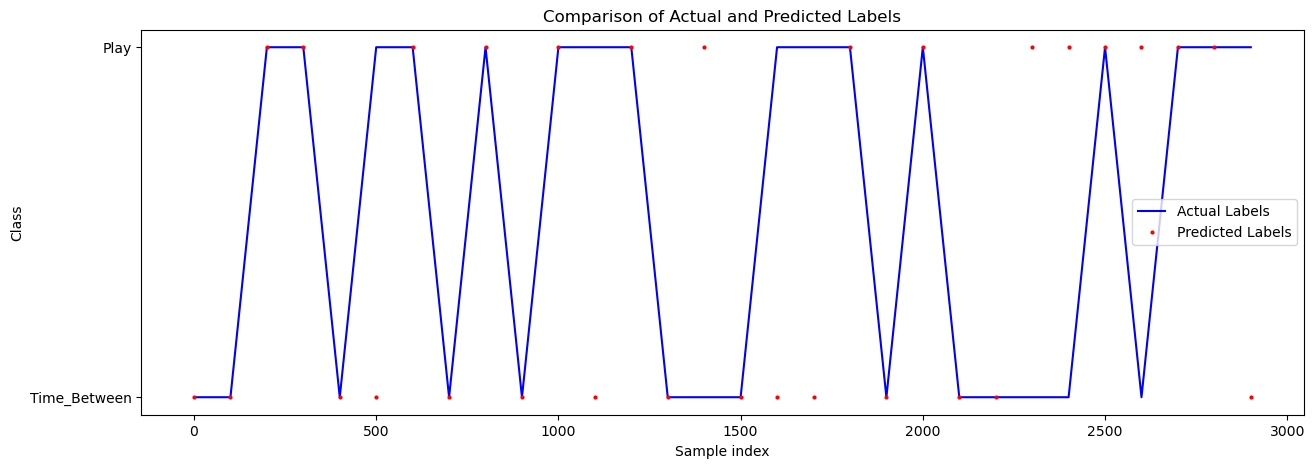

In [13]:
def evaluate_model(model_path, dataloaders, dataset_sizes, device):
    # Load the trained model
    model = cnn_lstm_model  # Stelle sicher, dass cnn_lstm_model vorher definiert ist
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []

    # Initialize the confusion matrix calculation
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels, _ in dataloaders['test']:  # Adjusted to handle three return values
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass to get outputs
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Update the running loss and corrects counters
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute final accuracy and loss for the entire test set
    final_acc = running_corrects.double() / dataset_sizes['test']
    final_loss = running_loss / dataset_sizes['test']
    cm = confusion_matrix(all_labels, all_preds)

    # Output the evaluation results
    print(f'Confusion Matrix:\n{cm}')
    print(f'Final Accuracy: {final_acc:.4f}')
    print(f'Final Loss: {final_loss:.4f}')

    # Plot the results
    plot_predictions(all_labels, all_preds)

def plot_predictions(all_labels, all_preds, step=100):
    # Unterabtastung: nur jeden 'step'-ten Punkt plotten
    indices = range(0, len(all_labels), step)
    sampled_labels = [all_labels[i] for i in indices]
    sampled_preds = [all_preds[i] for i in indices]

    plt.figure(figsize=(15, 5))
    plt.plot(indices, sampled_labels, label='Actual Labels', linestyle='-', marker='', color='b')
    plt.plot(indices, sampled_preds, label='Predicted Labels', linestyle='', marker='o', markersize=2, color='r')
    plt.title('Comparison of Actual and Predicted Labels')
    plt.xlabel('Sample index')
    plt.ylabel('Class')
    plt.yticks([0, 1], ['Time_Between', 'Play'])
    plt.legend()
    plt.show()

# Configuration for evaluation
model_path = 'best_model_1.pth'  # Path to your model file
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume dataloaders and dataset_sizes are already defined
# dataloaders = {'test': DataLoader(...)}  # Make sure to define this correctly
# dataset_sizes = {'test': len(test_dataset)}  # And this

# Call the evaluation function
evaluate_model(model_path, dataloaders, dataset_sizes, device)

In [ ]:
def evaluate_model(model_path, dataloaders, dataset_sizes, device):
    # Load the trained model
    model = cnn_lstm_model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []

    # Initialize the confusion matrix calculation
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels, _ in dataloaders['test']:  # Adjusted to handle three return values
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass to get outputs
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Update the running loss and corrects counters
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute final accuracy and loss for the entire test set
    final_acc = running_corrects.double() / dataset_sizes['test']
    final_loss = running_loss / dataset_sizes['test']
    cm = confusion_matrix(all_labels, all_preds)

    # Output the evaluation results
    print(f'Confusion Matrix:\n{cm}')
    print(f'Final Accuracy: {final_acc:.4f}')
    print(f'Final Loss: {final_loss:.4f}')

# Configuration for evaluation
model_path = 'best_model_play.pth'  # Path to your model file
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume dataloaders and dataset_sizes are already defined
# dataloaders = {'test': DataLoader(...)}  # Make sure to define this correctly
# dataset_sizes = {'test': len(test_dataset)}  # And this

# Call the evaluation function
evaluate_model(model_path, dataloaders, dataset_sizes, device)



